In [325]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
import seaborn as sns
import scipy.stats as stats

In [326]:
redfin = pd.read_csv('../1_data_raw/redfin_market_tracker_LI.csv')
redfin.head()

,Unnamed: 0,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,1146,2017-08-01,2017-08-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.018610,0.165706,-0.031015,-0.045004,0.094444,0.002420,-0.014083,"Nassau County, NY",35004.0,2023-10-29 14:25:50
1,2300,2018-02-01,2018-02-28,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.144231,0.138462,-0.039621,0.030618,0.000000,-0.133333,-0.090909,"Nassau County, NY",35004.0,2023-10-29 14:25:50
2,2885,2021-10-01,2021-10-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,0.034615,0.148148,0.010217,-0.151852,0.071429,-0.261905,-0.011905,"Nassau County, NY",35004.0,2023-10-29 14:25:50
3,4326,2023-08-01,2023-08-31,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.135338,0.052632,0.002632,-0.072368,0.600000,0.327273,0.336842,"Nassau County, NY",35004.0,2023-10-29 14:25:50
4,4380,2013-04-01,2013-04-30,30,county,5,1996,f,"Suffolk County, NY",NaN,...,-0.005694,0.178679,0.036528,-0.010062,0.148196,-0.005650,0.016120,"Nassau County, NY",35004.0,2023-10-29 14:25:50


In [327]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1406 non-null   int64  
 1   period_begin                    1406 non-null   object 
 2   period_end                      1406 non-null   object 
 3   period_duration                 1406 non-null   int64  
 4   region_type                     1406 non-null   object 
 5   region_type_id                  1406 non-null   int64  
 6   table_id                        1406 non-null   int64  
 7   is_seasonally_adjusted          1406 non-null   object 
 8   region                          1406 non-null   object 
 9   city                            0 non-null      float64
 10  state                           1406 non-null   object 
 11  state_code                      1406 non-null   object 
 12  property_type                   14

Fernando: I noticed Interest rates weren't given. We can use a different dataset to merge them

In [328]:
# merge with interest rate csv data
interest = pd.read_csv('../1_data_raw/avg_interest_rates.csv')
interest['date'] = pd.to_datetime(interest['date']).dt.strftime('%Y-%m')
redfin['interest_rate'] = redfin['period_begin'].apply(lambda x: interest[interest['date'] == pd.to_datetime(x).strftime('%Y-%m')]['rate'].values[0])

By inspection, City is the only category with all null values, so we will drop it. We will also drop the last updated column because it isn't a real-estate metric.

In [329]:
redfin.drop(columns=['city', 'last_updated'], inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1406 non-null   int64  
 1   period_begin                    1406 non-null   object 
 2   period_end                      1406 non-null   object 
 3   period_duration                 1406 non-null   int64  
 4   region_type                     1406 non-null   object 
 5   region_type_id                  1406 non-null   int64  
 6   table_id                        1406 non-null   int64  
 7   is_seasonally_adjusted          1406 non-null   object 
 8   region                          1406 non-null   object 
 9   state                           1406 non-null   object 
 10  state_code                      1406 non-null   object 
 11  property_type                   1406 non-null   object 
 12  property_type_id                14

Now we'll drop the columns that are repetitive or not useful for the topic.

In [330]:
drop_columns = ['median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price_mom', 'median_list_price_yoy', 
                'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'median_ppsf_mom', 'median_ppsf_yoy', 'homes_sold_mom',
                'homes_sold_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy',
                'inventory_mom', 'inventory_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'median_dom_mom',
                'median_dom_yoy', 'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list_mom', 
                'sold_above_list_yoy', 'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks_mom',
                'off_market_in_two_weeks_yoy', "property_type_id", 'table_id','median_ppsf','median_list_ppsf',
                'Unnamed: 0']
redfin.drop(columns=drop_columns,inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   period_begin                    1406 non-null   object 
 1   period_end                      1406 non-null   object 
 2   period_duration                 1406 non-null   int64  
 3   region_type                     1406 non-null   object 
 4   region_type_id                  1406 non-null   int64  
 5   is_seasonally_adjusted          1406 non-null   object 
 6   region                          1406 non-null   object 
 7   state                           1406 non-null   object 
 8   state_code                      1406 non-null   object 
 9   property_type                   1406 non-null   object 
 10  median_sale_price               1406 non-null   float64
 11  median_list_price               1403 non-null   float64
 12  homes_sold                      14

Now we subset the rows that need to be converted from string to numeric

In [331]:
to_encode = list(redfin.select_dtypes(include='object').columns)
to_encode

['period_begin',
 'period_end',
 'region_type',
 'is_seasonally_adjusted',
 'region',
 'state',
 'state_code',
 'property_type',
 'parent_metro_region']

We inspect the number of unique values in each of those rows to check the possibility of one-hot-encoding. Also noted is that none of these columns have null values. 

In [332]:
redfin[to_encode].nunique()

period_begin              141
period_end                141
region_type                 1
is_seasonally_adjusted      1
region                      2
state                       1
state_code                  1
property_type               5
parent_metro_region         1
dtype: int64

In [333]:
redfin.nunique()

period_begin                       141
period_end                         141
period_duration                      1
region_type                          1
region_type_id                       1
is_seasonally_adjusted               1
region                               2
state                                1
state_code                           1
property_type                        5
median_sale_price                  643
median_list_price                  158
homes_sold                         621
pending_sales                      621
new_listings                       713
inventory                          977
months_of_supply                   200
median_dom                         197
avg_sale_to_list                  1404
sold_above_list                    946
price_drops                       1190
off_market_in_two_weeks            880
parent_metro_region                  1
parent_metro_region_metro_code       1
interest_rate                      108
dtype: int64

We will drop the columns with only one unique value because if the value is constant, it will not provide any information on the changes in data points.

In [334]:
ex_columns = ['region_type', 'is_seasonally_adjusted', 'state', 'state_code', 'parent_metro_region']
for column in ex_columns:
    to_encode.remove(column)
ex_columns.append("region_type_id")
ex_columns.append("period_duration")
ex_columns.append("parent_metro_region_metro_code")
redfin.drop(columns=ex_columns,inplace=True)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   period_begin             1406 non-null   object 
 1   period_end               1406 non-null   object 
 2   region                   1406 non-null   object 
 3   property_type            1406 non-null   object 
 4   median_sale_price        1406 non-null   float64
 5   median_list_price        1403 non-null   float64
 6   homes_sold               1406 non-null   float64
 7   pending_sales            1388 non-null   float64
 8   new_listings             1403 non-null   float64
 9   inventory                1406 non-null   float64
 10  months_of_supply         1406 non-null   float64
 11  median_dom               1406 non-null   float64
 12  avg_sale_to_list         1405 non-null   float64
 13  sold_above_list          1406 non-null   float64
 14  price_drops             

The columns period_begin and period_end have many unique values, which makes one-hot-encoding difficult. We will inspect the values in the column to see if any other transformation is possible.

In [335]:
date_columns = ['period_begin', 'period_end']
for column in date_columns:
    to_encode.remove(column)
redfin[date_columns].head()

,period_begin,period_end
0,2017-08-01,2017-08-31
1,2018-02-01,2018-02-28
2,2021-10-01,2021-10-31
3,2023-08-01,2023-08-31
4,2013-04-01,2013-04-30


These columns appear to be dates. Datetime objects aren't numeric so there are several ways we can approach this. One way is to convert the string object into a datetime object, which can then be turned into an ordinal value. 

In [336]:
redfin_dates = pd.to_datetime(redfin[date_columns].stack())
redfin_dates = redfin_dates.map(dt.datetime.toordinal).unstack()
redfin_dates

,period_begin,period_end
0,736542,736572
1,736726,736753
2,738064,738094
3,738733,738763
4,734959,734988
...,...,...
1401,734716,734746
1402,736116,736145
1403,735689,735718
1404,737303,737332


Now we drop the original date columns and add in the converted date columns

In [337]:
redfin.drop(columns=date_columns,inplace=True)
redfin = redfin.join(redfin_dates)

In [338]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   1406 non-null   object 
 1   property_type            1406 non-null   object 
 2   median_sale_price        1406 non-null   float64
 3   median_list_price        1403 non-null   float64
 4   homes_sold               1406 non-null   float64
 5   pending_sales            1388 non-null   float64
 6   new_listings             1403 non-null   float64
 7   inventory                1406 non-null   float64
 8   months_of_supply         1406 non-null   float64
 9   median_dom               1406 non-null   float64
 10  avg_sale_to_list         1405 non-null   float64
 11  sold_above_list          1406 non-null   float64
 12  price_drops              1395 non-null   float64
 13  off_market_in_two_weeks  1388 non-null   float64
 14  interest_rate           

We can use the one-hot-encoder from sci-kit-learn to transform the rest of the string object columns into numeric columns

In [339]:
encoder = OneHotEncoder(handle_unknown='error', sparse=False)
redfin_enc = pd.DataFrame(encoder.fit_transform(redfin[to_encode]))
redfin_enc.columns = encoder.get_feature_names_out(to_encode)
redfin_enc.head()

c:\Users\Fefe\anaconda3\envs\irisu\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,"region_Nassau County, NY","region_Suffolk County, NY",property_type_All Residential,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0


We will now replace the original columns with the encoded ones

In [340]:
redfin.drop(columns=to_encode,inplace=True)
redfin.drop(columns=date_columns,inplace=True)
redfin = redfin.join(redfin_enc)
redfin = redfin.join(redfin_dates)

In [341]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   median_sale_price                        1406 non-null   float64
 1   median_list_price                        1403 non-null   float64
 2   homes_sold                               1406 non-null   float64
 3   pending_sales                            1388 non-null   float64
 4   new_listings                             1403 non-null   float64
 5   inventory                                1406 non-null   float64
 6   months_of_supply                         1406 non-null   float64
 7   median_dom                               1406 non-null   float64
 8   avg_sale_to_list                         1405 non-null   float64
 9   sold_above_list                          1406 non-null   float64
 10  price_drops                              1395 no

We will check the columns that have null values

In [342]:
null_condition = np.sum(redfin.isnull()) != 0
redfin.columns[null_condition]

Index(['median_list_price', 'pending_sales', 'new_listings',
       'avg_sale_to_list', 'price_drops', 'off_market_in_two_weeks'],
      dtype='object')

In [343]:
to_impute = ['median_list_price', 'pending_sales',
            'new_listings', 'avg_sale_to_list', 'price_drops',
            'off_market_in_two_weeks']
mean_values = redfin[to_impute].mean()
redfin[to_impute] = redfin[to_impute].fillna(value=mean_values)
for colname in to_impute:
    print("{} missing values count :{}".format(colname, np.sum(redfin[colname].isnull(), axis = 0)))

median_list_price missing values count :0
pending_sales missing values count :0
new_listings missing values count :0
avg_sale_to_list missing values count :0
price_drops missing values count :0
off_market_in_two_weeks missing values count :0


In [344]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   median_sale_price                        1406 non-null   float64
 1   median_list_price                        1406 non-null   float64
 2   homes_sold                               1406 non-null   float64
 3   pending_sales                            1406 non-null   float64
 4   new_listings                             1406 non-null   float64
 5   inventory                                1406 non-null   float64
 6   months_of_supply                         1406 non-null   float64
 7   median_dom                               1406 non-null   float64
 8   avg_sale_to_list                         1406 non-null   float64
 9   sold_above_list                          1406 non-null   float64
 10  price_drops                              1406 no

In [345]:
redfin.head()

,median_sale_price,median_list_price,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,sold_above_list,...,interest_rate,"region_Nassau County, NY","region_Suffolk County, NY",property_type_All Residential,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse,period_begin,period_end
0,253750.0,369900.0,256.0,180.0,225.0,694.0,2.7,57.0,0.968593,0.093750,...,3.93,0.0,1.0,0.0,1.0,0.0,0.0,0.0,736542,736572
1,395000.0,399000.0,13.0,13.0,17.0,65.0,5.0,84.0,0.955198,0.230769,...,4.22,0.0,1.0,0.0,0.0,1.0,0.0,0.0,736726,736753
2,475000.0,520500.0,13.0,14.0,12.0,27.0,2.1,21.0,1.023050,0.384615,...,2.99,0.0,1.0,0.0,0.0,0.0,0.0,1.0,738064,738094
3,540000.0,599000.0,19.0,15.0,18.0,19.0,1.0,29.0,1.031189,0.578947,...,6.90,0.0,1.0,0.0,0.0,0.0,0.0,1.0,738733,738763
4,300000.0,349997.0,823.0,776.0,2335.0,8311.0,10.1,141.0,0.948178,0.100851,...,3.54,0.0,1.0,1.0,0.0,0.0,0.0,0.0,734959,734988


Winsorizing the dependent variable

In [346]:
redfin['label'] = stats.mstats.winsorize(redfin['median_sale_price'], limits=[0.01,0.01])
difference = redfin['median_sale_price'] - redfin['label']
difference.unique()

array([      0.,   -2000.,  -25000.,  650000.,   -4000.,  225000.,
       -125000., -110000.,  310000.,  347500.,  -20000.,  160000.,
        -30000.,  -15000.,  338000.,  -62341.,   26875.,  -82000.,
        349000.,   -5625.,   12000.,  125000.,  102000.,   34000.,
        200000.])

Removing original column

In [347]:
redfin.drop(columns='median_sale_price', inplace=True)

Checking correlations

In [348]:
redfin.corr().head()

,median_list_price,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,sold_above_list,price_drops,...,"region_Nassau County, NY","region_Suffolk County, NY",property_type_All Residential,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse,period_begin,period_end,label
median_list_price,1.000000,0.002069,0.100114,-0.041030,-0.253365,-0.335933,-0.342282,0.448829,0.476862,0.049656,...,0.595794,-0.595794,0.000951,0.000951,0.000951,0.000951,-0.003823,0.755853,0.755836,0.706794
homes_sold,0.002069,1.000000,0.933456,0.891277,0.815846,-0.223777,-0.211737,0.234031,0.218889,0.060156,...,-0.080187,0.080187,0.652815,-0.295978,-0.415495,0.480676,-0.424290,0.095336,0.095377,0.065368
pending_sales,0.100114,0.933456,1.000000,0.921906,0.719388,-0.218350,-0.222349,0.282003,0.281486,0.098430,...,-0.064191,0.064191,0.611184,-0.292081,-0.396642,0.455447,-0.379942,0.178193,0.178224,0.123599
new_listings,-0.041030,0.891277,0.921906,1.000000,0.882581,-0.140827,-0.124202,0.134427,0.118527,0.092468,...,-0.082007,0.082007,0.643787,-0.294460,-0.408446,0.473025,-0.416134,-0.016489,-0.016478,-0.006111
inventory,-0.253365,0.815846,0.719388,0.882581,1.000000,-0.056951,-0.008076,-0.053337,-0.083997,0.060366,...,-0.102253,0.102253,0.625398,-0.278345,-0.393316,0.451432,-0.407349,-0.254605,-0.254594,-0.152323


In [349]:
corrs = redfin.corr()['label']
corrs

median_list_price                          0.706794
homes_sold                                 0.065368
pending_sales                              0.123599
new_listings                              -0.006111
inventory                                 -0.152323
months_of_supply                          -0.209392
median_dom                                -0.228706
avg_sale_to_list                           0.299341
sold_above_list                            0.395888
price_drops                                0.042374
off_market_in_two_weeks                    0.211408
interest_rate                              0.226366
region_Nassau County, NY                   0.418951
region_Suffolk County, NY                 -0.418951
property_type_All Residential              0.037218
property_type_Condo/Co-op                 -0.466436
property_type_Multi-Family (2-4 Unit)      0.182333
property_type_Single Family Residential    0.080369
property_type_Townhouse                    0.167412
period_begin

In [350]:
corrs_sorted = corrs.sort_values(ascending=False)
corrs_sorted

label                                      1.000000
median_list_price                          0.706794
period_end                                 0.558701
period_begin                               0.558686
region_Nassau County, NY                   0.418951
sold_above_list                            0.395888
avg_sale_to_list                           0.299341
interest_rate                              0.226366
off_market_in_two_weeks                    0.211408
property_type_Multi-Family (2-4 Unit)      0.182333
property_type_Townhouse                    0.167412
pending_sales                              0.123599
property_type_Single Family Residential    0.080369
homes_sold                                 0.065368
price_drops                                0.042374
property_type_All Residential              0.037218
new_listings                              -0.006111
inventory                                 -0.152323
months_of_supply                          -0.209392
median_dom  

In [351]:
top_two_corr = list(corrs_sorted.index[1:3])
top_two_corr

['median_list_price', 'period_end']

In [352]:
top_two_corr.append('label')
redfin_sub = redfin[top_two_corr]
redfin_sub.head()

,median_list_price,period_end,label
0,369900.0,736572,253750.0
1,399000.0,736753,395000.0
2,520500.0,738094,475000.0
3,599000.0,738763,540000.0
4,349997.0,734988,300000.0


c:\Users\Fefe\anaconda3\envs\irisu\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


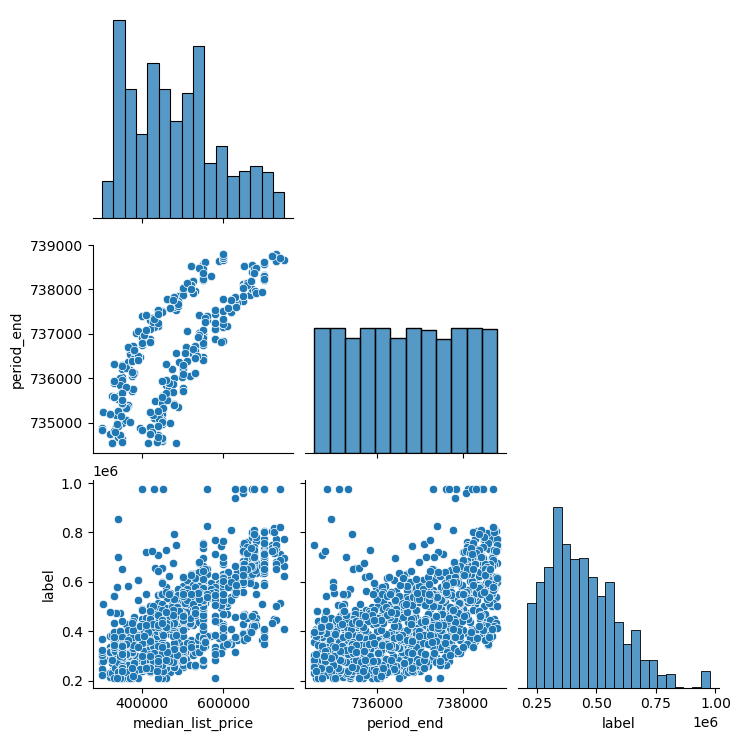

In [353]:
sns.pairplot(redfin_sub, corner=True)

In [295]:
redfin.to_csv('../3_data_cleaned/redfin_market_tracker_LI_cleanup_S.csv', index=False)
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   median_list_price                        1406 non-null   float64
 1   homes_sold                               1406 non-null   float64
 2   pending_sales                            1406 non-null   float64
 3   new_listings                             1406 non-null   float64
 4   inventory                                1406 non-null   float64
 5   months_of_supply                         1406 non-null   float64
 6   median_dom                               1406 non-null   float64
 7   avg_sale_to_list                         1406 non-null   float64
 8   sold_above_list                          1406 non-null   float64
 9   price_drops                              1406 non-null   float64
 10  off_market_in_two_weeks                  1406 no